Short description:

I'm new to machine learning, and for my very first project, I've chosen a typical task in Supervised learning: predicting the target numeric value, in my case of a car, based on a given set of features, such as model, year, price, transmission, mileage, fuel type, tax, miles per gallon (mpg), and engine size. I'm building my solution based on the book 'Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow' by Aurélien Géron. The dataset I'm using can be found at the following link: https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes?select=merc.csv. The author provides multiple .csv files in the archive, but I've opted to work with just one, named 'merc', which includes data for 13,119 different cars. To predict the approximate price of a car, I'll utilize a Supervised, Batch learning approach with a Model-based methodology. 


Firstly, we need to specify the required imports and set application constraints, ensuring a Python version equal to or greater than 3.5 and Scikit-Learn version equal to or greater than 0.20. Following that, default font sizes are configured, and a directory is defined along with a function to store our plots

In [91]:
import sys
import sklearn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from sklearn.impute import SimpleImputer

assert sys.version_info >= (3, 5)
assert sklearn.__version__ >= "0.20"


%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

The next step is to download data from our .csv file into a Pandas DataFrame. We can use the head() method to display the first 5 rows of the .csv file.

In [92]:
import pandas as pd

PROJECT_ROOT_DIR = os.getcwd()

def load_cars_data(project_root_dir=PROJECT_ROOT_DIR):
    csv_path = os.path.join(PROJECT_ROOT_DIR, "data/merc.csv")
    return pd.read_csv(csv_path)

In [93]:
cars = load_cars_data()
cars.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,SLK,2005,5200,Automatic,63000,Petrol,325,32.1,1.8
1,S Class,2017,34948,Automatic,27000,Hybrid,20,61.4,2.1
2,SL CLASS,2016,49948,Automatic,6200,Petrol,555,28.0,5.5
3,G Class,2016,61948,Automatic,16000,Petrol,325,30.4,4.0
4,G Class,2016,73948,Automatic,4000,Petrol,325,30.1,4.0


There are several non-numeric values, such as model, transmission, and fuel type. We can analyze them using the 'value_counts()' method. In Machine Learning algorithms, it is common to deal with a numeric representation of a parameter. There are several methods of conversion, one of which I will use at a later stage.

In [94]:
cars['model'].value_counts()

model
 C Class      3747
 A Class      2561
 E Class      1953
 GLC Class     960
 GLA Class     847
 B Class       591
 CL Class      511
 GLE Class     461
 SL CLASS      260
 CLS Class     237
 V Class       207
 S Class       197
 GL Class      121
 SLK            95
 CLA Class      86
 X-CLASS        82
 M Class        79
 GLS Class      74
 GLB Class      19
 G Class        15
 CLK             7
Name: count, dtype: int64

We can also use describe() method to see the summary of all numeric attributes. Also, I found that 'engineSize' column has cars with 0 engine size, so I decided to remove it here

In [95]:
cars.describe()

,year,price,mileage,tax,mpg,engineSize
count,13110.000000,13110.000000,13110.000000,13110.000000,13110.000000,13110.000000
mean,2017.300153,24705.881465,21931.125324,129.906941,55.163318,2.073394
std,2.216759,11836.776679,21158.172918,65.178587,15.218308,0.569907
min,1970.000000,650.000000,1.000000,0.000000,1.100000,1.300000
25%,2016.000000,17450.000000,6087.000000,125.000000,45.600000,1.800000
50%,2018.000000,22480.000000,15181.500000,145.000000,56.500000,2.000000
75%,2019.000000,28980.000000,31729.750000,145.000000,64.200000,2.100000
max,2020.000000,159999.000000,259000.000000,580.000000,217.300000,6.200000


Final way to have a feel of our DataStructure is to plot a histogram of each numeric value. It is done to better understand the data you are dealing with.

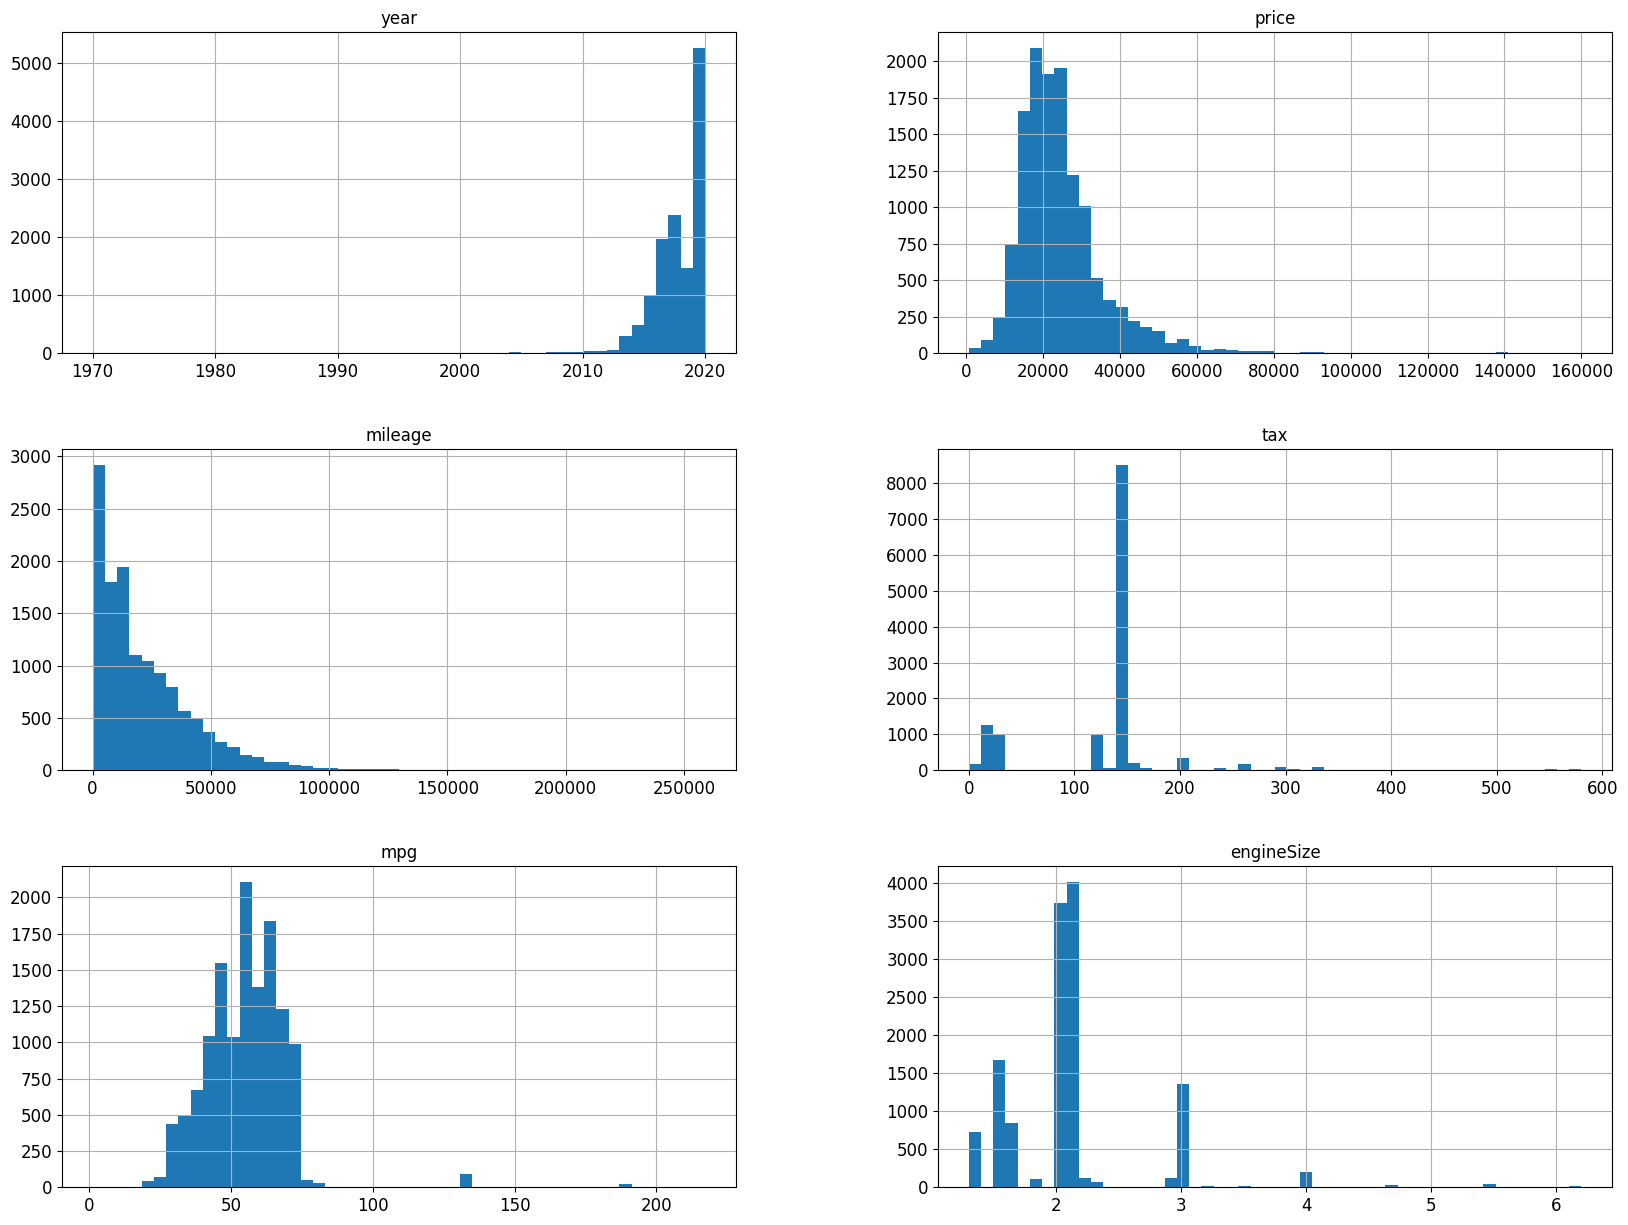

In [96]:
%matplotlib inline
cars.hist(bins=50, figsize=(20,15))
plt.show()

You may have a reasonable question: why do we do this? The answer is to better understand the data involved in the research, since you will need this information for things like data cleaning, feature engineering, and creating a test set. 
Also, I can notice that some of the histograms have a heavy-tailed distribution. The mileage histogram, in particular, has a long-tailed distribution, which is a bit harder for some ML algorithms to detect patterns in data. 
Most of the data has very different scales, that I will change later in this project.

The next step is to create a test set. But you cannot just randomly pick 20% of your dataset (20% of the dataset is usually taken as a test set, but it could be lower than 20% if the dataset is huge), since results of the prediction could be significantly biased. We can use so called stratified sampling: dataset set is divided into subgroups called strata and the right number of instances is sampled from each stratum to make sure the test set is representative. Now I need to choose a feature that is the most correlated to the price of a vehicle, it could be year or mileage (those attributes are numeric values), so to perform stratified sampling on the particular parameter. I have made an assumption that it's a mileage. Using Pandas method 'cut()' I'm dividing mileage attribute into 5 categories, 0-25000 miles is 1, 25000-50000 miles is 2 and so on.

<Axes: >

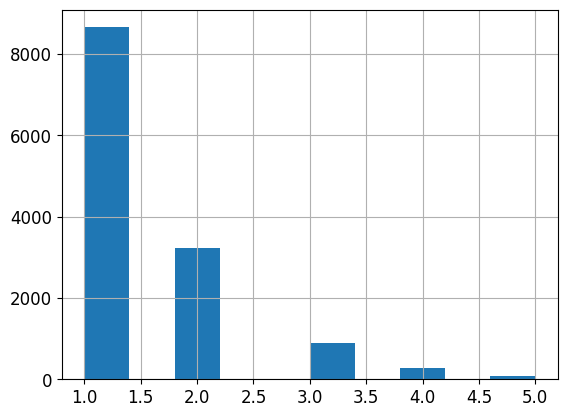

In [97]:
cars['mileage_cat'] = pd.cut(cars['mileage'],
                              bins=[0, 25000, 50000, 75000, 110000, np.inf],
                              labels=[1, 2, 3, 4, 5])

cars['mileage_cat'].hist()

Now we are ready for stratified sampling based on the mileage category. I will use StratifiedShuffleSplit class from Scikit-Learn library.

In [98]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(cars, cars['mileage_cat']):
    stratified_train_set = cars.loc[train_index]
    stratified_test_set = cars.loc[test_index]

stratified_test_set["mileage_cat"].value_counts() / len(stratified_test_set)

mileage_cat
1    0.659802
2    0.245614
3    0.067887
4    0.021358
5    0.005339
Name: count, dtype: float64

As evident in the 'mileage' histogram, cars with mileage between 0-25000 have the highest quantity among all other cars. Approximately 66% of the test set comprises cars with this specific mileage range. This stratification is implemented to prevent biased results.
However, I still need to eliminate the 'mileage_cat' attribute to restore the data to its original state.

In [99]:
for set_ in (stratified_train_set, stratified_test_set):
    set_.drop("mileage_cat", axis=1, inplace=True)

In this section I will look at correlations between data parameters using 'corr()' method. Unfortunately, it is not possible to calculate correlation coefficient between numeric and non-numeric values. 
According to the data below 'mileage' attribute seem to have the greater correlation (it has negative correlation, meaning that as 'mileage' growth 'price' drops).

In [100]:
cars = stratified_train_set.copy()
numeric_columns = cars.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = cars[numeric_columns].corr()
correlation_matrix["price"].sort_values(ascending=False)

price         1.000000
year          0.523350
engineSize    0.482888
tax           0.279901
mpg          -0.444016
mileage      -0.537662
Name: price, dtype: float64

Correlation coefficient can be checked using 'scatter_matrix()' function. Most promising attributes are 'mileage', 'year' and 'engineSize', let's focus on them.

array([[<Axes: xlabel='price', ylabel='price'>,
        <Axes: xlabel='mileage', ylabel='price'>,
        <Axes: xlabel='year', ylabel='price'>,
        <Axes: xlabel='engineSize', ylabel='price'>],
       [<Axes: xlabel='price', ylabel='mileage'>,
        <Axes: xlabel='mileage', ylabel='mileage'>,
        <Axes: xlabel='year', ylabel='mileage'>,
        <Axes: xlabel='engineSize', ylabel='mileage'>],
       [<Axes: xlabel='price', ylabel='year'>,
        <Axes: xlabel='mileage', ylabel='year'>,
        <Axes: xlabel='year', ylabel='year'>,
        <Axes: xlabel='engineSize', ylabel='year'>],
       [<Axes: xlabel='price', ylabel='engineSize'>,
        <Axes: xlabel='mileage', ylabel='engineSize'>,
        <Axes: xlabel='year', ylabel='engineSize'>,
        <Axes: xlabel='engineSize', ylabel='engineSize'>]], dtype=object)

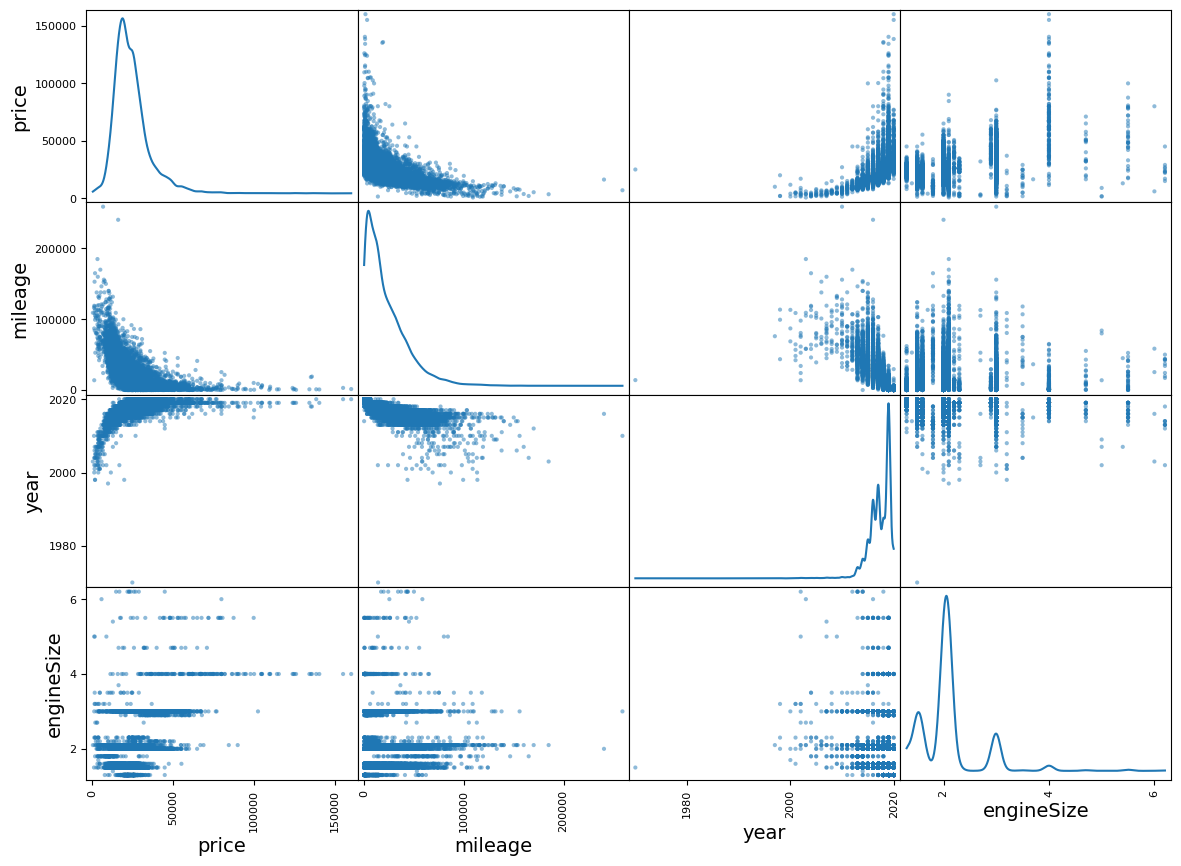

In [101]:
%matplotlib inline
from pandas.plotting import scatter_matrix 
attributes = ['price', 'mileage', 'year','engineSize']
scatter_matrix(cars[attributes], figsize=(14,10), diagonal='kde')

Due to the fact that the correlation between 'price' and 'mileage' appears to be the most promising, I'll focus on exploring this relationship in more detail. I plan to create a scatter plot specifically for 'price' and 'mileage,' zooming in on a certain range of mileage to better analyze any patterns or trends within that specific region.


<Axes: xlabel='mileage', ylabel='price'>

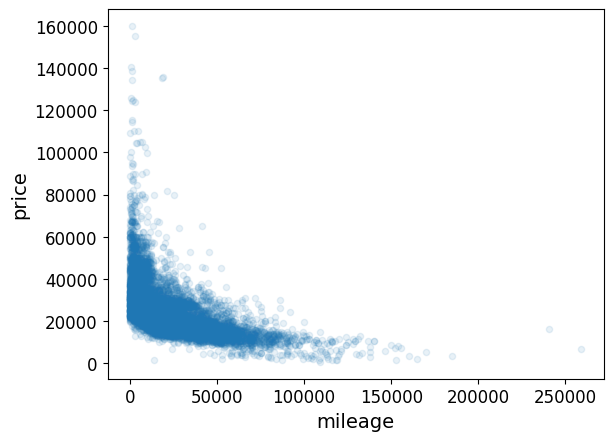

In [102]:
cars.plot(kind='scatter', x='mileage', y='price', alpha=0.1)

This plot illustrates a strong correlation with minimal outlying points between 'price' and 'mileage.' These outliers, which are intended to be removed for the ML algorithm to avoid learning from them, are relatively scarce. Conversely, a contrasting trend is evident in the plot between 'price' and 'year.' Consequently, the choice between 'mileage' and 'year' for stratified sampling appears to make little difference.

The section above aimed to provide insights on assessing the impact of an attribute on the price. In this part, I will delve into 'feature engineering,' where I will add or remove attributes from our dataset that, in my opinion, could influence price prediction. One idea is to create new attributes by combining existing ones, such as 'mileage' and 'year' to form 'miles_per_year,' or 'mpg' and 'engineSize' into 
'fuel_efficiency.'
Regarding the 'year' attribute, given that the maximum year is 2020 and assuming the data was gathered in 2020, I'll create the new attribute 'miles_per_year' by considering today as 2021 for this calculation.


In [103]:
cars['fuel_efficiency'] = cars['mpg']/cars['engineSize']
cars['miles_per_year'] = cars['mileage']/(2021 - cars['year'])
numeric_columns = cars.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = cars[numeric_columns].corr()
correlation_matrix["price"].sort_values(ascending=False)

price              1.000000
year               0.523350
engineSize         0.482888
tax                0.279901
miles_per_year    -0.440891
mpg               -0.444016
fuel_efficiency   -0.499455
mileage           -0.537662
Name: price, dtype: float64

The newly created attributes turned out to be less informative than anticipated. Nonetheless, it's time to prepare our data for the machine learning algorithm. Luckily, this dataset doesn't contain any missing values, allowing us to skip that step and proceed to handle text data.
One approach to handle text data is by using the 'OneHotEncoder' class.


In [104]:
from sklearn.preprocessing import OneHotEncoder

cars = stratified_train_set.drop(['price'], axis=1)
cars_labels = stratified_train_set['price'].copy()

encoder = OneHotEncoder()
cars_cat = cars[['model', 'transmission', 'fuelType']]

cars_cat_1hot = encoder.fit_transform(cars_cat)
cars_cat_1hot.toarray() 
encoder.categories_

[array([' A Class', ' B Class', ' C Class', ' CL Class', ' CLA Class',
        ' CLK', ' CLS Class', ' E Class', ' G Class', ' GL Class',
        ' GLA Class', ' GLB Class', ' GLC Class', ' GLE Class',
        ' GLS Class', ' M Class', ' S Class', ' SL CLASS', ' SLK',
        ' V Class', ' X-CLASS'], dtype=object),
 array(['Automatic', 'Manual', 'Other', 'Semi-Auto'], dtype=object),
 array(['Diesel', 'Hybrid', 'Other', 'Petrol'], dtype=object)]

I'm done with transforming non-numeric attributes to numeric one. However, I still need to create a custom Transformer to automate training and testing processes, for this purpose I'm using BaseEstimator and TransformerMixin interfaces from scikit-learn, since I want to have interoperability with scikit-learn Pipelines. One notable aspect is the optional inclusion of the 'miles_per_year' attribute. I've made this attribute optional to explore its impact on model performance and gain insights into its significance in the results. For instance, by making 'miles_per_year' optional, I aim to assess whether the model's predictive accuracy improves or declines based on its inclusion

In [105]:
from sklearn.base import BaseEstimator, TransformerMixin

year_ix, mileage_ix, mpg_ix, engineSize_ix = 0, 1, 3, 4

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_miles_per_year = True):
        self.add_miles_per_year = add_miles_per_year
    
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        fuel_efficiency = X.iloc[:, mpg_ix]/X.iloc[:, engineSize_ix]
        if self.add_miles_per_year:
            miles_per_year = X.iloc[:, mileage_ix]/(2021 - X.iloc[:, year_ix])
            return np.c_[X, fuel_efficiency, miles_per_year]
        else:
            return np.c_[X, fuel_efficiency]
        

Feature scaling plays a crucial role in machine learning projects, especially when working with algorithms that are sensitive to varying data ranges, potentially leading to biased results. Applying normalization or standardization is key to facilitating the construction of more accurate machine learning models. In this context, I opted for standardization over normalization. Standardization is less influenced by outliers in the dataset, providing a robust solution. Although standardization doesn't constrain the data to a specific range, such as 0 to 1, this limitation is not a concern, as only neural networks typically expect input data within the 0 to 1 range.

In [106]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

cat_attributes = ['model', 'transmission', 'fuelType']
cars_num = cars.drop(cat_attributes, axis=1)

num_pipeline = Pipeline([
    ('attribute_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cars_num_trans = num_pipeline.fit_transform(cars_num)

In the step above I created a pipeline for numerical columns, but it would be more convenient to handle numerical and categorical columns simultaneously. For this task there is ColumnTransformer class from scikit-learn. 

In [107]:
from sklearn.compose import ColumnTransformer

num_attributes = list(cars_num)

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attributes),
    ('cat', OneHotEncoder(), cat_attributes),
])

cars_prepared = full_pipeline.fit_transform(cars)


I've created preprocessing pipeline that gets full cars data and transforms it to an appropriate form.
The last step is to select and train a model. According to the NFL (No Free Lunch) theorem you cannot assume that one model is better than another without making an assumptions about your data, for instance linear regression assumes that data is linear and all the disturbances is simply a noise that can be ignored. Lets see how linear regression model performs on our dataset.

In [108]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(cars_prepared, cars_labels)

LinearRegression()

In [109]:
some_data = cars.iloc[:5]
some_labels = cars_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", lr.predict(some_data_prepared))

Predictions:  [38560.49161149 16080.50927881 46088.28291628 23952.21587959
 27491.12791873]


In [110]:
print("Labels: ", list(some_labels))

Labels:  [68900, 14850, 46481, 23299, 29990]


In [111]:
from sklearn.metrics import mean_squared_error

cars_predictions = lr.predict(cars_prepared)
l_mse = mean_squared_error(cars_labels, cars_predictions)
l_rmse = np.sqrt(l_mse)
l_rmse

5912.516131096922

While the overall performance of the model is not exceptional, there is a noticeable positive trend in the predicted data. The significant difference in the third result can be attributed to our assumption of a linear relationship. This deviation is particularly evident with the 'V Class,' where the average price was around 33,000, but an outlier with a price of 89,990 had a substantial impact on the prediction. Despite these limitations, the linear regression model provides a foundation, and although it may perform well in certain scenarios, we acknowledge that it falls short of meeting all our requirements. Now we can also try a DecisionTreeRegressor.

In [112]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(cars_prepared, cars_labels)

cars_predictions = tree_reg.predict(cars_prepared)
tree_mse = mean_squared_error(cars_labels, cars_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

183.31963659346604

An accuracy of 186 seems impressive for this dataset. However, I suspect that the model may have overfit the data significantly. To obtain a more robust evaluation of the model's performance, it is enough to use Cross-Validation. Scikit-Learn has a K-fold cross-validation feature.

In [113]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, cars_prepared, cars_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

def print_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Std: ", scores.std())

print_scores(tree_rmse_scores)

Scores:  [4761.36483174 3871.37513485 3678.08777759 4120.08922027 4230.59683449
 3836.16663173 3938.490194   3645.31409518 3657.17000723 3841.63123015]
Mean:  3958.028595722414
Std:  323.86240382090745


I use -scores, since cross_val_scores expects a utility function in a form of "greater is better", so the scoring function is an opposite of the MSE. Now I see that Decision Tree indeed overfit the results. Also, there is a measure of how precise our estimates are , in a form of standard deviation (±379).
I'd like to also check how Linear Regression performs using Cross-Validation.

In [114]:
lin_scores = cross_val_score(lr, cars_prepared, cars_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

print_scores(lin_rmse_scores)

Scores:  [4991.7579671  5862.13193506 5689.59640293 6725.35346432 7612.02635688
 5118.97676051 5433.7577641  5566.49639239 5959.10090921 6688.81170674]
Mean:  5964.800965923256
Std:  774.9308869701965


As I thought, results didn't change drastically. 
RandomForestRegressor is one more model, that is even more powerful than DecisionTreeRegressor, since it was built on top of it (this is called Ensemble Learning). 

In [115]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()
rf_reg.fit(cars_prepared, cars_labels)

cars_predictions = rf_reg.predict(cars_prepared)
rf_mse = mean_squared_error(cars_labels, cars_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

1135.5657761221894

In [116]:
rf_scores = cross_val_score(rf_reg, cars_prepared, cars_labels, scoring='neg_mean_squared_error', cv=10)
rf_rmse_scores = np.sqrt(-rf_scores)

print_scores(rf_rmse_scores)

Scores:  [4041.87336171 2704.3940699  2886.05845763 3112.6850499  3556.2160188
 2929.31875311 2693.59145055 2928.52404426 2769.79699768 3060.58996291]
Mean:  3068.304816644552
Std:  402.7331323679925


The result of RandomForestRegressor is promising, however the score on the training set is still much more lower, meaning that the model is overfitting the training set. We can try training different models and find the more promising ones or try to find more data or regularize the model. I will try SVR (Support Vector Regression) model with different kernel parameters.

In [117]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)

svr_rbf.fit(cars_prepared, cars_labels)
svr_lin.fit(cars_prepared, cars_labels)
svr_poly.fit(cars_prepared, cars_labels)

cars_predictions = svr_rbf.predict(cars_prepared)
svr_rbf_mse = mean_squared_error(cars_labels, cars_predictions)
svr_rbf_rmse = np.sqrt(svr_rbf_mse)
print("RBF model: ", svr_rbf_rmse)

cars_predictions =svr_lin.predict(cars_prepared)
svr_lin_mse = mean_squared_error(cars_labels, cars_predictions)
svr_lin_rmse = np.sqrt(svr_lin_mse)
print("Linear model: ", svr_lin_rmse)

cars_predictions = svr_poly.predict(cars_prepared)
svr_poly_mse = mean_squared_error(cars_labels, cars_predictions)
svr_poly_rmse = np.sqrt(svr_poly_mse)
print("Polynomial model: ", svr_poly_rmse)


RBF model:  6839.382076583426
Linear model:  6345.637080805681
Polynomial model:  5515.613245395014


In [118]:
svr_rbf_scores = cross_val_score(svr_rbf, cars_prepared, cars_labels, 
                                 scoring='neg_mean_squared_error', cv=10)
svr_rbf_rmse_scores = np.sqrt(-svr_rbf_scores)
print("RBF model: ")
print_scores(svr_rbf_rmse_scores)

svr_lin_scores = cross_val_score(svr_lin, cars_prepared, cars_labels, 
                                 scoring='neg_mean_squared_error', cv=10)
svr_lin_rmse_scores = np.sqrt(-svr_lin_scores)
print("Linear model: ")
print_scores(svr_lin_rmse_scores)

svr_poly_scores = cross_val_score(svr_poly, cars_prepared, cars_labels,
                                 scoring='neg_mean_squared_error', cv=10)
svr_poly_rmse_scores = np.sqrt(-svr_poly_scores)
print("Polynomial model: ")
print_scores(svr_poly_rmse_scores)

RBF model: 
Scores:  [5369.82926834 6367.27136251 7020.10021548 8884.86433963 8097.58498889
 6368.24142889 5684.52340337 5442.0875431  7397.34368104 8051.21710388]
Mean:  6868.3063335137795
Std:  1160.2503403415003
Linear model: 
Scores:  [5090.78906336 6147.38223525 6307.13809391 7668.61045009 8169.36527056
 5357.69748165 5513.26025764 5314.7715228  6293.7059975  7209.06492527]
Mean:  6307.178529802314
Std:  1007.8019276205831
Polynomial model: 
Scores:  [4522.0778966  5187.13630078 5702.83932654 7038.50437762 6697.74794947
 4879.20140007 4665.96903173 4504.06973276 5580.85299191 6437.00193717]
Mean:  5521.540094464566
Std:  885.985368512989


Those models don't seem to perform good on the given dataset, so I'll stick to RandomForestRegressor and DecisionTreeRegressor. It could be a good idea to involve neural networks, but I want to leave it for further projects.

We have selected one model from the previous section for fine-tuning, aiming to mitigate overfitting by simplifying the model. This involves restricting a parameter to a certain extent or slightly reducing the model's degree of freedom, which essentially achieves the same goal. This process, known as hyperparameter tuning, seeks to make the model simpler.

There are two methods for fine-tuning: using the GridSearchCV class or employing an ensemble method. While GridSearchCV can be extended to RandomSearchCV, the latter would require considerable time to explore all possible parameter combinations, despite being considered the more comprehensive approach. Unfortunately, time constraints limit our ability to perform an exhaustive search, and therefore, we opt for using GridSearchCV for now.

In [120]:
from sklearn.model_selection import GridSearchCV

model_params = [{
    'n_estimators': [3, 10, 30],
    'max_features': [2,4,6,8],
    'bootstrap': [False]
    },
    {
    'n_estimators': [3, 10],
    'max_features': [2,3,4],
    }]

rand_for_reg = RandomForestRegressor()
grid_search = GridSearchCV(rand_for_reg, model_params, cv=10, scoring="neg_mean_squared_error", 
                           return_train_score=True)
grid_search.fit(cars_prepared, cars_labels)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


3989.5217812525857 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
3376.61303148596 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
3314.0114043108993 {'bootstrap': False, 'max_features': 2, 'n_estimators': 30}
3844.7775529365563 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
3239.633374415287 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
3133.8196666864546 {'bootstrap': False, 'max_features': 4, 'n_estimators': 30}
3648.760759849593 {'bootstrap': False, 'max_features': 6, 'n_estimators': 3}
3218.2684794139223 {'bootstrap': False, 'max_features': 6, 'n_estimators': 10}
3150.439534880543 {'bootstrap': False, 'max_features': 6, 'n_estimators': 30}
3644.21451665534 {'bootstrap': False, 'max_features': 8, 'n_estimators': 3}
3188.3835252279982 {'bootstrap': False, 'max_features': 8, 'n_estimators': 10}
3057.3571125530293 {'bootstrap': False, 'max_features': 8, 'n_estimators': 30}
4142.795309852863 {'max_features': 2, 'n_estimators': 3}
3517.9

According to the above results Fine_Tuning didn't give us results that were expected, the best result is for {'bootstrap': False, 'max_features': 8, 'n_estimators': 30}, so we can keep increasing max_features, since adding n_estimators may make the model more complex and lead to overfitting.  

In [121]:
model_params1 = [{
    'n_estimators': [10, 30],
    'max_features': [8, 10, 12],
    'bootstrap': [False]
    },
]

rand_for_reg1 = RandomForestRegressor()
grid_search1 = GridSearchCV(rand_for_reg1, model_params1, cv=10, scoring="neg_mean_squared_error", 
                           return_train_score=True)
grid_search1.fit(cars_prepared, cars_labels)

cvres1 = grid_search1.cv_results_
for mean_score, params in zip(cvres1["mean_test_score"], cvres1["params"]):
    print(np.sqrt(-mean_score), params)

3174.149681990218 {'bootstrap': False, 'max_features': 8, 'n_estimators': 10}
3058.763602041703 {'bootstrap': False, 'max_features': 8, 'n_estimators': 30}
3202.962598863973 {'bootstrap': False, 'max_features': 10, 'n_estimators': 10}
3053.3665247076156 {'bootstrap': False, 'max_features': 10, 'n_estimators': 30}
3066.8383583614172 {'bootstrap': False, 'max_features': 12, 'n_estimators': 10}
2976.0076162866517 {'bootstrap': False, 'max_features': 12, 'n_estimators': 30}


In [122]:
model_params2 = [{
    'n_estimators': [50],
    'max_features': [8, 10, 12],
    'bootstrap': [False]
    },
]

rand_for_reg2 = RandomForestRegressor()
grid_search2 = GridSearchCV(rand_for_reg2, model_params2, cv=10, scoring="neg_mean_squared_error", 
                           return_train_score=True)
grid_search2.fit(cars_prepared, cars_labels)

cvres2 = grid_search2.cv_results_
for mean_score, params in zip(cvres2["mean_test_score"], cvres2["params"]):
    print(np.sqrt(-mean_score), params)

3029.7430379237003 {'bootstrap': False, 'max_features': 8, 'n_estimators': 50}
2992.6178620932415 {'bootstrap': False, 'max_features': 10, 'n_estimators': 50}
3015.602034013882 {'bootstrap': False, 'max_features': 12, 'n_estimators': 50}


The optimal result obtained is "2976.0076162866517 {'bootstrap': False, 'max_features': 12, 'n_estimators': 30}". Despite attempting to enhance the model's performance by adding 20 trees to the forest, there was no noticeable improvement in the results. It is plausible that increasing the value of max_features might enhance precision; however, this adjustment could potentially lead to overfitting.

As previously noted, due to time constraints, I am maintaining the current result. Nevertheless, a more in-depth investigation could be conducted using the RandomSearchCV class for a comprehensive exploration of hyperparameter combinations.

In [144]:
grid_search1.best_estimator_.feature_importances_

array([1.44694422e-01, 1.68772321e-01, 4.42545169e-02, 1.43137359e-01,
       1.00795580e-01, 2.46622938e-01, 3.30660355e-02, 2.35039605e-02,
       3.07050425e-03, 5.45398854e-03, 7.10993266e-04, 3.76604216e-04,
       7.32536505e-06, 3.19815760e-04, 3.97436641e-03, 8.61641180e-03,
       2.92877561e-04, 1.46434213e-03, 4.78654020e-05, 9.80354933e-03,
       6.51193101e-03, 1.28504331e-03, 6.88227762e-04, 1.48621921e-02,
       6.24242266e-04, 5.91749867e-04, 2.35756137e-03, 2.56065089e-03,
       2.33278755e-03, 1.20943106e-02, 7.64563406e-06, 2.80845867e-03,
       6.45439004e-03, 8.51246621e-04, 4.26949261e-05, 6.94109097e-03])

In [145]:
added_attributes = ["fuel_efficiency", "miles_per_year"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_1hot_attribute_model = list(cat_encoder.categories_[0])
cat_1hot_attribute_trans = list(cat_encoder.categories_[1])
cat_1hot_attribute_fuel = list(cat_encoder.categories_[2])
attributes = (num_attributes + added_attributes + cat_1hot_attribute_model 
              + cat_1hot_attribute_trans + cat_1hot_attribute_fuel)
sorted(zip(grid_search1.best_estimator_.feature_importances_, attributes), reverse=True)

[(0.2466229378174888, 'fuel_efficiency'),
 (0.16877232100531384, 'mileage'),
 (0.14469442185687678, 'year'),
 (0.14313735853110068, 'mpg'),
 (0.10079558017453659, 'engineSize'),
 (0.04425451692102442, 'tax'),
 (0.03306603554798907, 'miles_per_year'),
 (0.023503960538892987, ' A Class'),
 (0.014862192097696163, ' S Class'),
 (0.012094310616896751, 'Manual'),
 (0.009803549331593914, ' GLC Class'),
 (0.008616411798568153, ' G Class'),
 (0.006941090970904566, 'Petrol'),
 (0.006511931009027478, ' GLE Class'),
 (0.006454390036836927, 'Diesel'),
 (0.0054539885372168855, ' C Class'),
 (0.0039743664131430545, ' E Class'),
 (0.0030705042485381353, ' B Class'),
 (0.002808458667929296, 'Semi-Auto'),
 (0.0025606508856971053, ' X-CLASS'),
 (0.0023575613667529407, ' V Class'),
 (0.002332787548549016, 'Automatic'),
 (0.0014643421251685032, ' GLA Class'),
 (0.0012850433055920027, ' GLS Class'),
 (0.0008512466212694798, 'Hybrid'),
 (0.0007109932664470482, ' CL Class'),
 (0.0006882277624485983, ' M Class

In [125]:
attributes = (num_attributes + added_attributes + list(cat_encoder.categories_) )
sorted(zip(grid_search2.best_estimator_.feature_importances_, attributes), reverse=True)

[(0.22966158600484313, 'fuel_efficiency'),
 (0.16497581145645274, 'year'),
 (0.15375418437288682, 'mpg'),
 (0.1312557660472967, 'mileage'),
 (0.09702594982000902, 'engineSize'),
 (0.047824338618579744, 'tax'),
 (0.047104460102025625, 'miles_per_year'),
 (0.021888018439776585,
  array([' A Class', ' B Class', ' C Class', ' CL Class', ' CLA Class',
         ' CLK', ' CLS Class', ' E Class', ' G Class', ' GL Class',
         ' GLA Class', ' GLB Class', ' GLC Class', ' GLE Class',
         ' GLS Class', ' M Class', ' S Class', ' SL CLASS', ' SLK',
         ' V Class', ' X-CLASS'], dtype=object)),
 (0.00530175281836117,
  array(['Diesel', 'Hybrid', 'Other', 'Petrol'], dtype=object)),
 (0.003101369538407456,
  array(['Automatic', 'Manual', 'Other', 'Semi-Auto'], dtype=object))]

'fuel_efficiency' turned out to be the most important attribute. Hopefully, I didn't make a mistake in the attribute order. 'full_pipeline' firstly processes numerical attributes + new attributes and then adds categorical attributes, so the order should be as stated above. This data gives as the fact, that we can drop fuel type and transmission, since they do not significantly contribute to the predictions. After this step it is useful to analyse the system behaviour, try removing outliers, uninformative attributes (this step is clear to me, but I want to move on in researching ML world, so I won't do this step right now. I just wanted to get an understanding of this process, and, hopefully, get some decent results)

It's time to evaluate system on the Test set:

In [126]:
final_model = grid_search2.best_estimator_

X_test = stratified_test_set.drop('price', axis=1)
y_test = stratified_test_set['price'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
final_rmse

3655.6420090031233

The preceding section presents the evaluation of the final error using {'bootstrap': False, 'max_features': 10, 'n_estimators': 50}. Initially, these parameters yielded a score of 2992. However, upon evaluation on the training set, it became apparent that having 50 estimators led to overfitting the results. It's possible that we fine-tuned the system to perform well on the validation set, but this does not necessarily imply good performance on the test set and in real-world scenarios.

In [148]:
final_model_8_max_features = grid_search.best_estimator_

X_test = stratified_test_set.drop('price', axis=1)
y_test = stratified_test_set['price'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model_8_max_features.predict(X_test_prepared)

final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
final_rmse

3404.3511460136824

For this assesment I used {'bootstrap': False, 'max_features': 10, 'n_estimators': 30}. Those parameters resulted in a lower test error. This could be because 'max_features' parameter represents the maximum number of features considered for splitting a node. A higher value allows the model to consider more features, potentially capturing more complex relationships in the data. However, too many features can lead to overfitting. As it , probably, was in the example below.

In [149]:
final_model_12_max_features = grid_search1.best_estimator_

X_test = stratified_test_set.drop('price', axis=1)
y_test = stratified_test_set['price'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model_12_max_features.predict(X_test_prepared)

final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
final_rmse

3473.5951665604757

In [150]:
import joblib

joblib.dump(final_model_8_max_features, "final_model_8_max_features.pkl")
joblib.dump(final_model_12_max_features, "final_model_12_max_features.pkl")

['final_model_12_max_features.pkl']

In the pursuit of developing a robust car price predictor, I embarked on a comprehensive project utilizing a diverse set of features to capture the nuances influencing vehicle prices. The journey involved data exploration, preprocessing like splitting dataset to train and test sets, feature engineering, data cleaning, creating a custom pipeline, model selection, cross-validation, fine-tuning, and evaluation.I initiated this project with the primary goal of gaining a fundamental understanding of building a machine learning system from the ground up. Throughout the process, I uncovered several critical aspects often overlooked in many machine learning systems, contributing to a more profound comprehension of this subject. For my next project, I plan to delve into the creation of a classification system.